 Importation librairies

In [1]:
# librairies
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, precision_score, precision_recall_curve, classification_report, confusion_matrix, accuracy_score
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from numpy import concatenate

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import scipy.io as sp

In [2]:
#traitement fichier.mat
dataset=sp.loadmat('breastw.mat')
X = dataset['X']
y = dataset['y']
#fin traitement mat

Modèles KNN / Statistique / Réseau de neurones + entrainement dataset

In [3]:
skf = StratifiedKFold(n_splits=10,shuffle=True) # équilibrage dataset

for train_index, test_index in skf.split(X,y):
    
    X_train, X_test = X[train_index,:], X[test_index,:]
    y_train, y_test = y[train_index], y[test_index]

    #copie pour semi-supervisé
    X_train_semiSup, y_train_semiSup = X[train_index,:], y[train_index]

    #Méthode Statistique Gaussienne
    model_gmm = GaussianMixture(n_components=2, covariance_type ='full', random_state = 0, max_iter=100)
    model_gmm.fit(X_train,y_train)
    y_pred_gmm = model_gmm.predict(X_test)
    y_scores_gmm = model_gmm.predict_proba(X_test)
    if precision_score(y_test,y_pred_gmm)< 0.15:
    
        y_pred_gmm = np.array([0 if label == 1 else 1 for label in y_pred_gmm])
        y_scores_gmm = 1-model_gmm.predict_proba(X_test)
        y_scores_gmm = y_scores_gmm[:, 1]
    else :
        y_scores_gmm = model_gmm.predict_proba(X_test)
        y_scores_gmm = y_scores_gmm[:, 1]
    #Fin méthode stat

    #Méthode KNN
    k=5
    #algo knn
    model_KNN = KNeighborsClassifier(n_neighbors=k)
    model_KNN.fit(X_train,y_train)
    y_pred_KNN = model_KNN.predict(X_test)
    model_PCA = PCA(n_components=2)
    data_reduced = model_PCA.fit_transform(X_test)
    #fin algo knn
    y_scores_KNN = model_KNN.predict_proba(X_test)
    y_scores_KNN = y_scores_KNN[:, 1]
    #Fin méthode KNN

    #Algorithme Réseau de neurones = Perceptron multicouches
    #Modèle1
    model_PMC_1 = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(8, 2), random_state=1)
    model_PMC_1.fit(X_train, y_train)
    y_pred_PMC_1= model_PMC_1.predict(X_test)
    #Modèle2
    model_PMC_2 = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(9, 2), random_state=1) #modif du nombre de couches cachées par ex ici 9
    model_PMC_2.fit(X_train, y_train)
    y_pred_PMC_2 = model_PMC_2.predict(X_test)
    #Fin alogo PMC
    y_scores_PMC_1 = model_PMC_1.predict(X_test)
    y_scores_PMC_2 = model_PMC_2.predict(X_test)
    #Fin méthode Réseaux de neurones

    #Méthode semi-supervisée
    for train_index_2, test_index_2 in skf.split(X_train_semiSup,y_train_semiSup):
        X_train_2, X_delab = X_train_semiSup[train_index_2,:], X_train_semiSup[test_index_2,:]
        y_train_2, y_delab = y_train_semiSup[train_index_2], y_train_semiSup[test_index_2]
        
        y_train_2 = np.ravel(y_train_2)
        X_train_mixed = concatenate((X_train_2, X_delab))

        y_delab = [-1 for i in range(len(y_delab))]
        y_delab = np.ravel(y_delab)

        #Algorithme SVC
        model_svc_semiSup = SVC()
        model_svc_semiSup.fit(X_train_2,y_train_2)
        y_delab = model_svc_semiSup.predict(X_delab)

        #Algorithme Gaussien semi-supervisé
        y_train_mixed = concatenate((y_delab,y_train_2))
        model_gmm_semiSup = GaussianMixture(n_components=2, covariance_type ='full', random_state = None, max_iter=100)
        model_gmm_semiSup.fit(X_train_mixed,y_train_mixed)
        y_pred_semiSup = model_gmm_semiSup.predict(X_test)

        if precision_score(y_test,y_pred_semiSup)< 0.15:
    
            y_pred_semiSup = np.array([0 if label == 1 else 1 for label in y_pred_semiSup])
            y_scores_gmm_semiSup = 1-model_gmm_semiSup.predict_proba(X_test)
            y_scores_gmm_semiSup = y_scores_gmm_semiSup[:, 1]
        else :
            y_scores_gmm_semiSup = model_gmm_semiSup.predict_proba(X_test)
            y_scores_gmm_semiSup = y_scores_gmm_semiSup[:, 1]


C:\Users\achan\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\achan\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\achan\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\achan\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for 

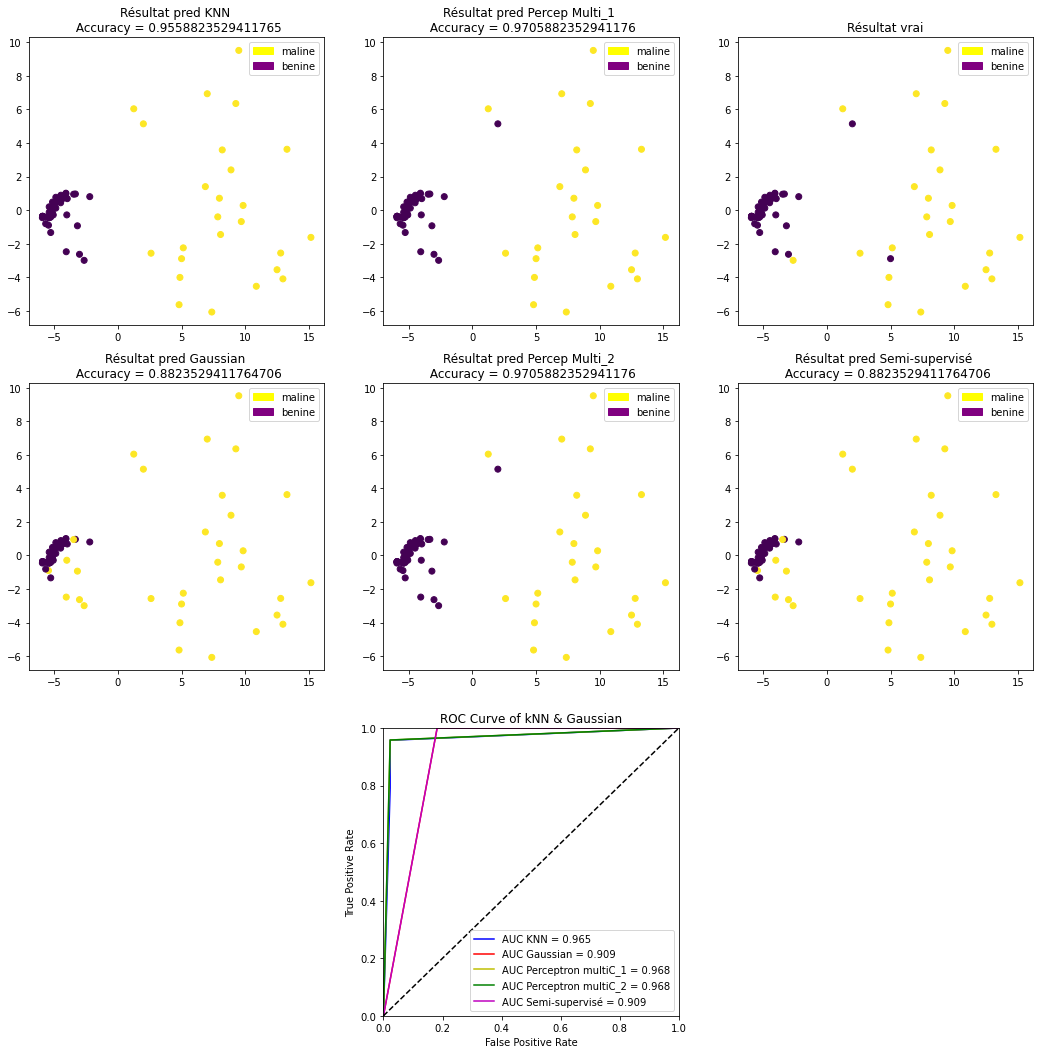

In [4]:
# Plot graphique

plt.figure(figsize=(18,18))

#Calculs Accuracy KNN
Accuracy_KNN = accuracy_score(y_test, y_pred_KNN)
Accuracy_gmm = accuracy_score(y_test, y_pred_gmm)
Accuracy_PMC_1 = accuracy_score(y_test, y_pred_PMC_1)
Accuracy_PMC_2 = accuracy_score(y_test, y_pred_PMC_2)
Accuracy_semiSup = accuracy_score(y_test, y_pred_semiSup)

#Nuage de points prédictif KNN
plt.subplot(3, 3, 1)
plt.scatter(data_reduced[:,0],data_reduced[:,1],c=y_pred_KNN) 
plt.title("Résultat pred KNN \n Accuracy = {}".format(Accuracy_KNN))
maline = mpatches.Patch(color='yellow', label='maline')
benine = mpatches.Patch(color='purple', label='benine')
plt.legend(handles=[maline,benine])

#Nuage de points prédictif Gaussien
plt.subplot(3, 3, 4)
plt.scatter(data_reduced[:,0],data_reduced[:,1],c=y_pred_gmm) 
plt.title("Résultat pred Gaussian \n Accuracy = {}".format(Accuracy_gmm))
maline = mpatches.Patch(color='yellow', label='maline')
benine = mpatches.Patch(color='purple', label='benine')
plt.legend(handles=[maline,benine])

#Nuage de points prédictif Perceptron multicouche modèle 1
plt.subplot(3, 3, 2)
plt.scatter(data_reduced[:,0],data_reduced[:,1],c=y_pred_PMC_1) 
plt.title("Résultat pred Percep Multi_1 \n Accuracy = {}".format(Accuracy_PMC_1))
maline = mpatches.Patch(color='yellow', label='maline')
benine = mpatches.Patch(color='purple', label='benine')
plt.legend(handles=[maline,benine])

#Nuage de points prédictif Perceptron multicouche modèle 2
plt.subplot(3, 3, 5)
plt.scatter(data_reduced[:,0],data_reduced[:,1],c=y_pred_PMC_2) 
plt.title("Résultat pred Percep Multi_2 \n Accuracy = {}".format(Accuracy_PMC_2))
maline = mpatches.Patch(color='yellow', label='maline')
benine = mpatches.Patch(color='purple', label='benine')
plt.legend(handles=[maline,benine])

#Nuage de points prédictif Semi-supervisé
plt.subplot(3, 3, 6)
plt.scatter(data_reduced[:,0],data_reduced[:,1],c=y_pred_semiSup) 
plt.title("Résultat pred Semi-supervisé \n Accuracy = {}".format(Accuracy_semiSup))
maline = mpatches.Patch(color='yellow', label='maline')
benine = mpatches.Patch(color='purple', label='benine')
plt.legend(handles=[maline,benine])

#Nuage de points vrai
plt.subplot(3, 3, 3)
plt.scatter(data_reduced[:,0],data_reduced[:,1],c=y_test) 
plt.title("Résultat vrai")
maline = mpatches.Patch(color='yellow', label='maline')
benine = mpatches.Patch(color='purple', label='benine')
plt.legend(handles=[maline,benine])

#  ROC curve
 #ROC pour KNN
fpr_KNN, tpr_KNN, threshold_KNN = roc_curve(y_test, y_scores_KNN) 
roc_auc_KNN = auc(fpr_KNN, tpr_KNN)
 #ROC pour Gaussien
fpr_gmm, tpr_gmm, thresholds_gmm = roc_curve(y_test,y_pred_gmm)
roc_auc_gmm = auc(fpr_gmm, tpr_gmm)
 #ROC pour Perceptron multicouche modèle 1
fpr_PMC_1, tpr_PMC_1, thresholds_PMC_1 = roc_curve(y_test,y_pred_PMC_1)
roc_auc_PMC_1 = auc(fpr_PMC_1, tpr_PMC_1)
 #ROC pour Perceptron multicouche modèle 2
fpr_PMC_2, tpr_PMC_2, thresholds_PMC_2 = roc_curve(y_test,y_pred_PMC_2)
roc_auc_PMC_2 = auc(fpr_PMC_2, tpr_PMC_2)
 #ROC pour Semi-supervisé
fpr_semiSup, tpr_semiSup, thresholds_semiSup = roc_curve(y_test,y_pred_semiSup)
roc_auc_semiSup = auc(fpr_semiSup, tpr_semiSup)

plt.subplot(3, 3, 8)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_KNN, tpr_KNN, 'b', label = 'AUC KNN = %0.3f' % roc_auc_KNN)
plt.plot(fpr_gmm, tpr_gmm, 'r', label = 'AUC Gaussian = %0.3f' % roc_auc_gmm)
plt.plot(fpr_PMC_1, tpr_PMC_1, 'y', label = 'AUC Perceptron multiC_1 = %0.3f' % roc_auc_PMC_1)
plt.plot(fpr_PMC_2, tpr_PMC_2, 'g', label = 'AUC Perceptron multiC_2 = %0.3f' % roc_auc_PMC_2)
plt.plot(fpr_semiSup, tpr_semiSup, 'm', label = 'AUC Semi-supervisé = %0.3f' % roc_auc_semiSup)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of kNN & Gaussian')
plt.show()
#fin graphique

In [5]:
# Matrice de  confusion, F1-score etc...

# Méthode KNN
result = confusion_matrix(y_test, y_pred_KNN)
print("Matrice de confusion KNN :")
print(result)
result1 = classification_report(y_test, y_pred_KNN)
print("Classification Report KNN :",)
print (result1)
print("Accuracy KNN :", Accuracy_KNN, "\n")

# Méthode Statistique Gaussien
result = confusion_matrix(y_test, y_pred_gmm)
print("Matrice de confusion Gaussien :")
print(result)
result1 = classification_report(y_test, y_pred_gmm)
print("Classification Report Gaussian :",)
print (result1)
print("Accuracy Gaussian :", Accuracy_gmm)

# Méthode Perceptron multicouche
result = confusion_matrix(y_test, y_pred_PMC_1)
print("Matrice de confusion Perceptron multicouche :")
print(result)
result1 = classification_report(y_test, y_pred_PMC_1)
print("Classification Report Perceptron multicouche :",)
print (result1)
print("Accuracy Perceptron multicouche :", Accuracy_PMC_1)

# Méthode Semi-supervisé
result = confusion_matrix(y_test, y_pred_semiSup)
print("Matrice de confusion Semi-supervisé :")
print(result)
result1 = classification_report(y_test, y_pred_semiSup)
print("Classification Report Semi-supervisé :",)
print (result1)
print("Accuracy Semi-supervisé :", Accuracy_semiSup)


Matrice de confusion KNN :
[[42  2]
 [ 1 23]]
Classification Report KNN :
              precision    recall  f1-score   support

           0       0.98      0.95      0.97        44
           1       0.92      0.96      0.94        24

    accuracy                           0.96        68
   macro avg       0.95      0.96      0.95        68
weighted avg       0.96      0.96      0.96        68

Accuracy KNN : 0.9558823529411765 

Matrice de confusion Gaussien :
[[36  8]
 [ 0 24]]
Classification Report Gaussian :
              precision    recall  f1-score   support

           0       1.00      0.82      0.90        44
           1       0.75      1.00      0.86        24

    accuracy                           0.88        68
   macro avg       0.88      0.91      0.88        68
weighted avg       0.91      0.88      0.88        68

Accuracy Gaussian : 0.8823529411764706
Matrice de confusion Perceptron multicouche :
[[43  1]
 [ 1 23]]
Classification Report Perceptron multicouche :
 